Luego de verificar los datos se procedio a implementar un modelo de arbol de decisión clasificador

In [62]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [63]:
# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [64]:
# Lectura de datos
# ------------------------------------------------------------------------------

data = pd.read_excel(r'E-Commerce_train.xlsx')
data_test = pd.read_excel(r'E-Commerce_test.xlsx')

df = data
df_test = data_test

Al tener variables categoricas en ambos datasets se procedio a reemplazar sus valores por numeros

In [65]:
df['Warehouse_block']=df['Warehouse_block'].map({'A':0,'B':1,'C':2,'D':3,'F':4})
df['Mode_of_Shipment']=df['Mode_of_Shipment'].map({'Flight':0,'Ship':1,'Road':2})
df['Product_importance']=df['Product_importance'].map({'low':0,'medium':1,'high':2})
df=pd.get_dummies(df,columns=['Gender'],drop_first=True)

In [66]:
df_test['Warehouse_block']=df_test['Warehouse_block'].map({'A':0,'B':1,'C':2,'D':3,'F':4})
df_test['Mode_of_Shipment']=df_test['Mode_of_Shipment'].map({'Flight':0,'Ship':1,'Road':2})
df_test['Product_importance']=df_test['Product_importance'].map({'low':0,'medium':1,'high':2})
df_test=pd.get_dummies(df_test,columns=['Gender'],drop_first=True)

In [67]:
# Se dropea las columnas ID de ambos datasets

df.drop(columns=['ID'])
df_test.drop(columns=['ID'])

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Gender_M
0,4,1,5,1,189,2,1,10,5248,1
1,3,1,5,3,150,2,2,9,4446,0
2,4,1,3,3,200,3,0,3,5739,1
3,0,1,5,1,133,2,1,1,4643,1
4,1,1,4,2,260,3,0,4,5504,1
...,...,...,...,...,...,...,...,...,...,...
1995,0,1,4,1,252,5,1,1,1538,0
1996,1,1,4,1,232,5,1,6,1247,0
1997,2,1,5,4,242,5,0,4,1155,0
1998,4,1,5,2,223,6,1,2,1210,1


In [68]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns ='Reached.on.Time_Y.N'),
                                        df['Reached.on.Time_Y.N'], test_size=0.3,
                                        random_state = 123
                                    )

In [69]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
            max_depth         = 5,
            criterion         = 'gini',
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=123)

Profundidad del árbol: 5
Número de nodos terminales: 15


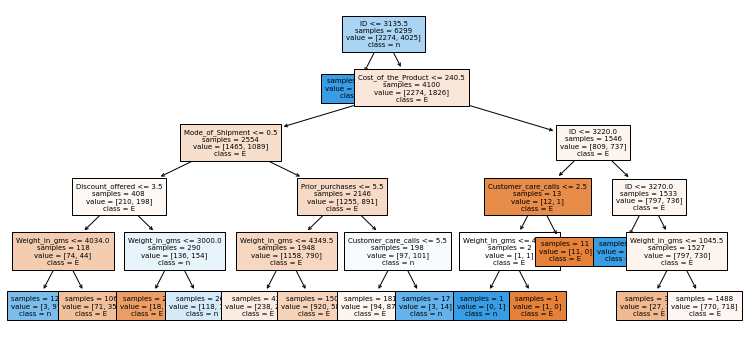

In [70]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = X_train.columns.tolist(),
            class_names   = 'Entregas a tiempo',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

In [71]:
# Error de test del modelo
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test,)

print("Matriz de confusión")
print("-------------------")
confusion_matrix(
    y_true    = y_test,
    y_pred    = predicciones
)

Matriz de confusión
-------------------


array([[924,  82],
       [705, 989]], dtype=int64)

In [72]:
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {accuracy}")

El accuracy de test es: 0.7085185185185185


In [73]:
print(f'El score del modelo es:, {recall_score(y_test, predicciones)}')

El score del modelo es:, 0.5838252656434475


In [76]:
# Se realiza la prediccion y se crea el dataframe que lo contega
# ------------------------------------------------------------------------------

predicciones2 = modelo.predict(X = df_test,)
j4carlos = pd.DataFrame(predicciones2, columns=['pred'])

In [75]:
# Se genera el .csv para exportar
# ------------------------------------------------------------------------------
j4carlos.to_csv("j4carlos.csv",index=False)